In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ete3

import os
from tqdm import tqdm
import pickle

from src.phylogenetic_signal import PagelsLambda
from src.ihmp import get_diffs
from src.greengenes import (
    parse_similarity_map, merge_otu_table, combine_similarity_maps
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%bash

# Download greengenes OTUs dataset, if necessary
if ! [ -d greengenes/data/gg_13_5_otus/ ]; then
    if ! [ -f greengenes/data/gg_13_5_otus.tar.gz ]; then
        wget -O greengenes/data/gg_13_5_otus.tar.gz \
            https://gg-sg-web.s3-us-west-2.amazonaws.com/downloads/greengenes_database/gg_13_5/gg_13_5_otus.tar.gz
    fi
    tar -xvf greengenes/data/gg_13_5_otus.tar.gz -C greengenes/data/
fi

In [4]:
# I load OTU tables using the basic iHMP scripts from earlier notebooks

data = {
    name: get_diffs(name, get_abundances=True, log=False)  # undo log transform
    for name in ["ibd", "moms", "t2d"]
}


In [5]:
# Sanity check 1: relative abundances continue to sum to 1
# They do!!!
similarity_map99 = parse_similarity_map(99)
similarity_map = similarity_map99
for x in [97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]:
    similarity_map = combine_similarity_maps(
        [similarity_map, parse_similarity_map(x)]
    )
    clustered = merge_otu_table(data["ibd"], similarity_map)
    s = clustered.sum(axis=1)
    print(f"{x} {clustered.shape} {s.min():.3f} {s.mean():.3f} {s.max():.3f}")


/home/phil/phylosig/src/greengenes.py:207: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_otu_table[cluster_id] = otu_table[existing_otus].sum(axis=1)


97 (98, 1370) 1.000 1.000 1.000
94 (98, 1171) 1.000 1.000 1.000
91 (98, 799) 1.000 1.000 1.000
88 (98, 536) 1.000 1.000 1.000
85 (98, 337) 1.000 1.000 1.000
82 (98, 203) 1.000 1.000 1.000
79 (98, 118) 1.000 1.000 1.000
76 (98, 82) 1.000 1.000 1.000
73 (98, 43) 1.000 1.000 1.000
70 (98, 24) 1.000 1.000 1.000
67 (98, 13) 1.000 1.000 1.000
64 (98, 8) 1.000 1.000 1.000
61 (98, 6) 1.000 1.000 1.000


In [6]:
import numpy as np

N = 100

x = np.random.rand(N, 1)
C = np.random.rand(N, N)
C = C + C.T  # Make symmetric
C = C @ C.T  # Make positive definite
C_inv = np.linalg.inv(C)
C_inv_slogdet = np.linalg.slogdet(C_inv)[1]
C_logdet = np.linalg.slogdet(C)[1]

# Quick sanity check: do our new expressions for lambda work?
one = np.ones(shape=(N, 1))
z0 = (np.linalg.pinv(one.T @ C_inv @ one) @ (one.T @ C_inv @ x)).item()
x0 = x - z0
sigma2 = x0.T @ C_inv @ x0  # (1, N) @ (N, N) @ (N, 1) = (1, 1)
sigma2 = sigma2 / (N - 1)
sigma2 = sigma2.item()
ll_num = -0.5 * x0.T @ C_inv @ x0 / sigma2
det = N * np.log(sigma2) + np.linalg.slogdet(C)[1]
ll_denom = 0.5 * (N * np.log(2 * np.pi) + det)
ll = (ll_num - ll_denom).item()

# New definitions
z0_new = (C_inv @ x).sum() / C_inv.sum().sum()
x0_new = x - z0_new
sigma2_new = x0_new.T @ C_inv @ x0_new / (N - 1)
# ll_new = N - 1 + N * np.log(2 * np.pi) + (N * np.log(sigma2_new) - C_inv_slogdet)
ll_new = 1 + np.log(2 * np.pi) + np.log(sigma2_new)
ll_new *= N
ll_new += C_logdet
ll_new -= 1
ll_new *= -0.5

ll2 = -0.5 * (
    N * (1 + np.log(2 * np.pi) + np.log(sigma2_new)) - C_inv_slogdet - 1
)

ll3 = (1 - N + C_inv_slogdet - N * (np.log(2 * np.pi * sigma2_new))) / 2

ll4 = (1 - C_logdet - N * (1 + np.log(2 * np.pi * sigma2_new))) / 2


# So this has the same argmin as log|C_inv| - N * log(sigma2_new)

assert np.allclose(z0, z0_new)
assert np.allclose(x0, x0_new)
assert np.allclose(sigma2, sigma2_new)
assert np.allclose(det, np.linalg.slogdet(C * sigma2)[1])
assert np.allclose(ll, ll_new)
assert np.allclose(ll, ll2)
assert np.allclose(ll, ll3)
assert np.allclose(ll, ll4)


In [7]:
# Quick sanity check 2: after all this, do we match seedplants example?

# Sanity check 2: agreement with textbook example
# The Garland (1992) data is not provided, so I'm going to use this example instead:
# https://github.com/simjoly/CourseComparativeMethods/blob/master/lecture6/PD.pdf

# Load data
traits = pd.read_csv(
    "./seedplants/traits.csv", sep=";", decimal=",", index_col=0
).dropna()
tree = ete3.Tree("./seedplants/tree.nwk", format=0)

# Match leaves to traits
pl = PagelsLambda(tree, memoized=True)
traits = traits.reindex(pl.leaf_order)

# Fit lambda for each trait
print("trait\t\tlambda\t\tlnL\t\tnull\t\tlikelihood ratio")
for col in traits.columns:
    if col == "Occurrence":
        continue
    try:
        pl.fit(traits[col].values)
        print(
            f"{col}",
            f"{pl.lam:.2f}",
            f"{pl.lnL:.2f}",
            f"{pl.null_lnL:.2f}",
            f"{np.exp(pl.lnL - pl.null_lnL):.0f}",
            sep="\t\t",
        )
    except Exception as e:
        print(f"{col}: {e}")
        pass

# Expected:

# trait   | lambda | lnL  | null
# --------+--------+------+-----
# maxH    | 0.49   |-206  | -207
# Wd      | 0.76   |  59  |   42
# Sm      | 0.91   |-521  | -531
# Shade   | 0.95   | -83  |  -88
# N       | 0.67   | -18  |  -41


100%|██████████| 65/65 [00:00<00:00, 2394.35it/s]


trait		lambda		lnL		null		likelihood ratio
Species name: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
maxH		0.49		-206.16		-206.46		1
Wd		0.76		59.49		52.71		882
Sm		0.90		-521.39		-530.68		10842
Shade		0.95		-82.55		-87.80		191
N		0.67		-17.56		-40.61		10168478657
height: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ShadeTol: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


In [27]:
# Get lambdas for each cutoff
from multiprocessing import Pool
from functools import partial

MEMOIZED = True
PRECISION = 3
similarity_map99 = parse_similarity_map(99)

lambdas = []
for name in ["ibd", "moms", "t2d"]:

    # It's actually faster to go by site, since inversion is O(n^2):
    for site in data[name].index.get_level_values("site").unique():
        data_site = data[name].loc[site]
        data_site = data_site.loc[:, data_site.sum(axis=0) > 0]

        similarity_map = similarity_map99  # Restart at 99
        for x in [99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]:

            # Non-redundancy check
            site_str = site.replace(" ", "_")
            outpath = f"./results/{name}_{site_str}_pls_cutoff{x}.tsv"
            pklpath = f"./results/{name}_{site_str}_pls_cutoff{x}.pkl"
            if os.path.exists(outpath):
                print(f"Skipping {outpath} because it already exists.")
                lambdas_cutoff_df = pd.read_csv(outpath, sep="\t")

            else:
                pass # Moved to external script
                # lambdas_cutoff = []

                # # Get GreenGenes data
                # if x == 99:  # Special case
                #     similarity_map = similarity_map99
                # else:
                #     similarity_map = combine_similarity_maps(
                #         [similarity_map, parse_similarity_map(x)]
                #     )

                # # Filter OTU table
                # clustered = merge_otu_table(data_site, similarity_map)
                # s = clustered.sum(axis=1)
                # print(
                #     x,
                #     clustered.shape,
                #     f"{s.min():.3f} {s.mean():.3f} {s.max():.3f}",
                # )

                # # Filter tree, init PagelsLambda
                # tree = ete3.Tree(
                #     f"./greengenes/data/gg_13_5_otus/trees/{x}_otus.tree",
                #     format=1,
                #     quoted_node_names=True,
                # )
                # tree.prune(clustered.columns)
                # pl = PagelsLambda(tree, memoized=MEMOIZED)
                # print(f"Tree has {len(pl.tree)} leaves.")

                # # # Change everything to float16 - this will save a lot of memory
                # # clustered = clustered.astype(np.float16)
                # # pl.C = pl.C.astype(np.float16)

                # # Get lambdas
                # for sample in tqdm(clustered.index):
                #     pl.fit(clustered.loc[sample], precision=PRECISION, method="optimize")
                #     lambdas_cutoff.append({"sample": sample, "lambda": np.round(pl.lam, PRECISION)})

                # lambdas_cutoff_df = pd.DataFrame(lambdas_cutoff)
                # lambdas_cutoff_df.to_csv(outpath, sep="\t")

            lambdas_cutoff_df["cutoff"] = x
            lambdas_cutoff_df["dataset"] = name
            lambdas_cutoff_df["site"] = site
            lambdas.append(lambdas_cutoff_df)

lambdas_df = pd.concat(lambdas)




Skipping ./results/ibd_feces_pls_cutoff99.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff97.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff94.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff91.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff88.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff85.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff82.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff79.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff76.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff73.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff70.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff67.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff64.tsv because it already exists.
Skipping ./results/ibd_feces_pls_cutoff61.tsv becau

In [9]:
leaves = tree.get_leaves()

two_leaves = np.random.choice(leaves, 2)
mrca = tree.get_common_ancestor(*two_leaves)
print(tree.get_distance(mrca))


0.0


In [10]:
two_leaves


array([Tree node 'SASP' (0x7f21a2a5f4c), Tree node 'ABBA' (0x7f21a2a5f64)],
      dtype=object)

In [11]:
fig = plt.figure(figsize=(30, 30), dpi=300)
plt.matshow(pl.C, fignum=0)


In [29]:
lambdas_df["site"].unique()

array(['feces', 'rectum', 'vagina', 'buccal mucosa', 'cervix of uterus',
       'unknown', 'nasal cavity'], dtype=object)

In [44]:
lambdas_df[lambdas_df["dataset"] == "t2d"]["site"].unique()

array(['feces', 'nasal cavity'], dtype=object)

In [51]:
lambdas_df[lambdas_df["dataset"] == "t2d"]["site"].unique()

array(['feces', 'nasal cavity'], dtype=object)

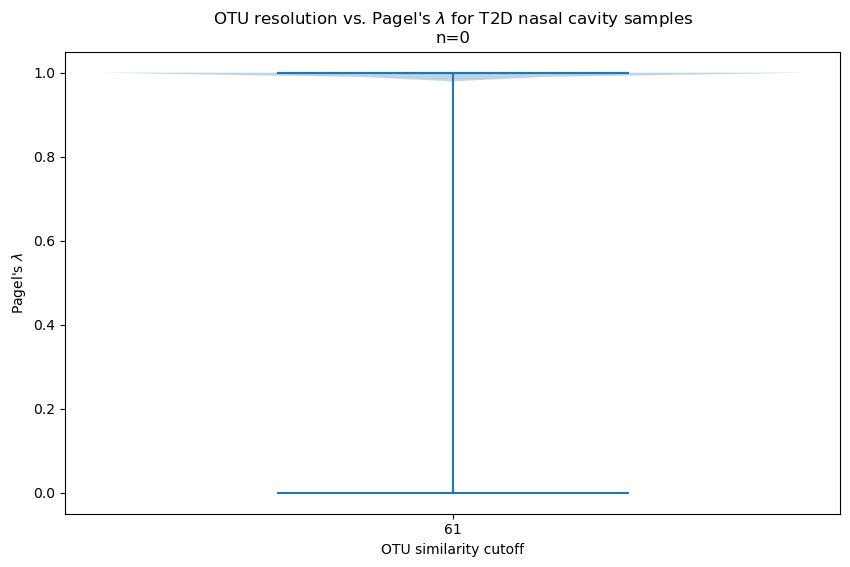

In [58]:
DATASET = "t2d" # ibd, moms, t2d
SITE = "nasal cavity" # feces, rectum, vagina, buccal mucosa, cervix of uterus, nasal cavity

fig, ax = plt.subplots(figsize=(10, 6))

site_df1 = lambdas_df.loc[lambdas_df["dataset"] == DATASET]
site_df2 = site_df1.loc[site_df1["site"] == SITE]
n_samples = len(site_df2[site_df2["cutoff"] == 99])

lams_to_plot = site_df2.groupby("cutoff")["lambda"].apply(list)

plt.violinplot(lams_to_plot, showmedians=True)
plt.xticks(range(1, len(lams_to_plot) + 1), lams_to_plot.index)
plt.xlabel("OTU similarity cutoff")
plt.ylabel("Pagel's $\lambda$")
plt.title(f"OTU resolution vs. Pagel's $\lambda$ for {DATASET.upper()} {SITE} samples\nn={n_samples}")
plt.show()
